#Necessary Imports

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import glob
import math

#Reading The Image

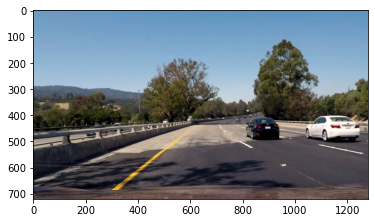

In [3]:
image = cv2.imread("test1.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [5]:
height = image.shape[0]
print(height)
width = image.shape[1]
print(width)

720
1280


#Functions

In [193]:
def show_image(image, title="title", cmap_type="gray"):
    plt.imshow(image, cmap_type)
    plt.title(title)

In [9]:
# applying gaussian blur
def gaussian_blur(image,height,width):
    return cv2.GaussianBlur(image,(height,width),0)

In [6]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255 # <-- This line altered for grayscale.
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [7]:
region_of_interest_vertices = [
    (0, height),
    (width / 2,400),
    (width, height),
]

#Using Grayscale, Gaussian Blur, Cropping the image and using binary threshold

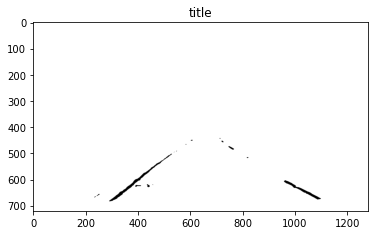

In [155]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cannyed_image = cv2.Canny(gray,100,200, L2gradient = True)
blurred = gaussian_blur(gray,7,7)
cropped_image = region_of_interest(
    blurred,
    np.array([region_of_interest_vertices], np.int32)
)

(T, threshInv) = cv2.threshold(cropped_image, 200, 255,cv2.THRESH_BINARY_INV)
#cv2.imshow("Threshold Binary Inverse", threshInv)
show_image(threshInv)

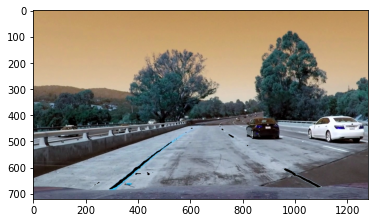

In [156]:
masked = cv2.bitwise_and(image, image, mask=threshInv)
plt.imshow(masked)

#show_image(masked)

#Sobel Transform and binary Image

In [86]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

gray = hls[:, :, 1]

s_channel = hls[:, :, 2]

In [87]:
sobel_kernel=7
mag_thresh=(3, 255)
s_thresh=(170, 255)

In [88]:
sobel_binary = np.zeros(shape=gray.shape, dtype=bool)
s_binary = sobel_binary
combined_binary = s_binary.astype(np.float32)

In [89]:
sobel_abs = np.abs(sobelx**2 + sobely**2)
sobel_abs = np.uint8(255 * sobel_abs / np.max(sobel_abs))

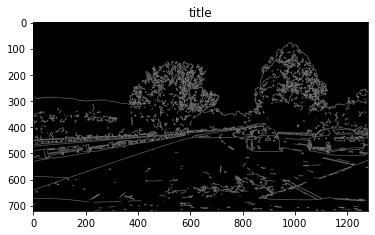

In [169]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7)
sobely = 0
#sobelxy = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7)
show_image(sobelx)
edges = cv2.Canny(gray, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Canny Edge Detection Image
show_image(edges)

In [170]:
sobel_binary[(sobel_abs > th[0]) & (sobel_abs <= th[1])] = 1

# Threshold color channel
s_binary[(s_channel >= sth[0]) & (s_channel <= sth[1])] = 1

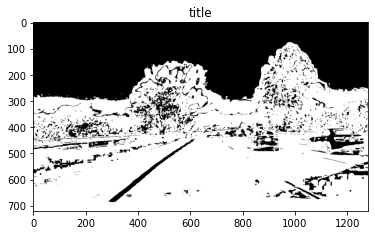

In [171]:
combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
combined_binary = np.uint8(255 * combined_binary / np.max(combined_binary))
show_image(combined_binary)

In [137]:
# src = ([700, 280], 
#               [450, 600], 
#               [660, 1100], 
#               [450, 670])


In [120]:
def masked_image(combined_binary):
    offset = 100
    mask_poly =np.array([[(0 + offset, image.shape[0]),
                            (image.shape[1] / 2.3, image.shape[0] / 1.65),
                            (image.shape[1] / 1.7, image.shape[0] / 1.65),
                            (image.shape[1], image.shape[0])]],
                          dtype=np.int)
    mask_img = np.zeros_like(combined_binary)
    ignore_mask_color = 255
    cv2.fillPoly(mask_img, mask_poly, ignore_mask_color)
    masked_edges = cv2.bitwise_and(combined_binary, mask_img)
    return masked_edges

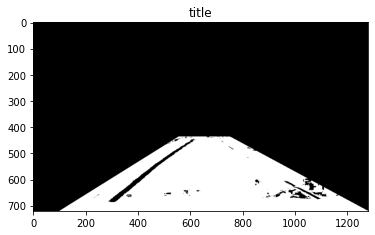

In [121]:
show_image(masked_image(combined_binary))

#Src and dst Points

In [186]:
src = [595, 452], \
          [685, 452], \
          [1110, image.shape[0]], \
          [220, image.shape[0]]
line_dst_offset = 100
dst = [src[3][0] + line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, src[2][1]], \
          [src[3][0] + line_dst_offset, src[3][1]]

#Perspective Transform Function

In [187]:
def warp(image, src, dst):

    src = np.float32([src])
    dst = np.float32([dst])
    
    return cv2.warpPerspective(image, cv2.getPerspectiveTransform(src, dst),
                               dsize=image.shape[0:2][::-1], flags=cv2.INTER_LINEAR)

#Using Sobel and Binary Image 

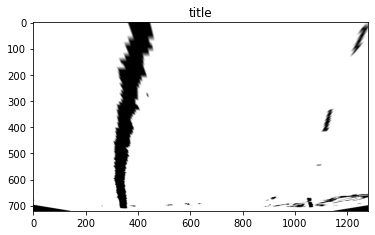

In [188]:
Perspective_img1=(warp(combined_binary,src,dst))
show_image(Perspective_img1)

#Using Gaussian Blur and Binary Thresholding 

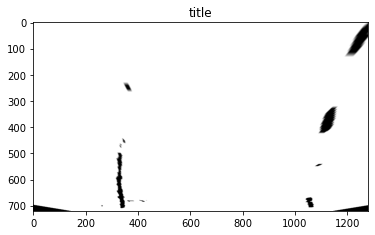

In [189]:
Perspective_img=(warp(threshInv,src,dst))
show_image(Perspective_img)

#Inverse Perspective Transform

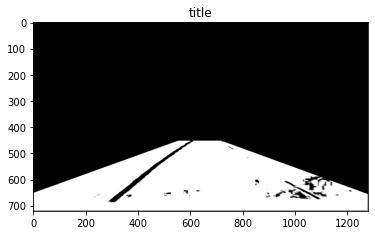

In [190]:
show_image(warp(Perspective_img1,dst,src))